# Sentiment Analysis on the Presidential and Vice-Presidential Debates between 1960-2024

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import textwrap

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import BertModel, BertTokenizer, AdamW
import torch
import os
from transformers import AutoTokenizer, AutoModelForCausalLM

from openai import OpenAI
from google.colab import userdata

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
df = pd.read_csv('presidential_clean.csv')

In [ ]:
df.head()

,actor,dialogue,date,Party
0,Bill Shadel,Good evening. Im Bill Shadel of ABC News. Its ...,1960-10-13,Moderator
1,Mr. Kennedy,"Good evening, Mr. Shadel.",1960-10-13,Democrat
2,Mr. Shadel,"And good evening to you, Vice President Nixon.",1960-10-13,Moderator
3,Mr. Nixon,"Good evening, Mr. Shadel.",1960-10-13,Republican
4,Mr. Shadel,And now to meet the panel of correspondents. F...,1960-10-13,Moderator


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9538 entries, 0 to 9537
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   actor     9538 non-null   object
 1   dialogue  9538 non-null   object
 2   date      9538 non-null   object
 3   Party     9538 non-null   object
dtypes: object(4)
memory usage: 298.2+ KB


In [ ]:
# Drop Moderator from Party column so we are only looking at the democrat and republican candidates' dialogue

df = df[df['Party'] != 'Moderator']

In [ ]:
df.Party.value_counts()

,count
Party,
Republican,3072
Democrat,2565
Independent,125


In [ ]:
# Drop Independent from Party column since there were only 2 instances and we are mostly focused on democratic/republican trends
df = df[df['Party'] != 'Independent']
df.Party.value_counts()

,count
Party,
Republican,3072
Democrat,2565


In [ ]:
# Split data by sentences for more in-depth sentiment analysis

def split_dialogue(row, max_length=250):
    # Split the dialogue into chunks based on input max_length
    chunks = textwrap.wrap(row['dialogue'], max_length)

    return pd.DataFrame({
        'actor': [row['actor']] * len(chunks),
        'dialogue': chunks,
        'date': [row['date']] * len(chunks),
        'Party': [row['Party']] * len(chunks)
    })

# Iterrate through df and apply split_dialogue
df_split = pd.concat([split_dialogue(row) for _, row in df.iterrows()], ignore_index=True)


In [ ]:
# View df_split to verify it was correct
df_split.head()

,actor,dialogue,date,Party
0,Mr. Kennedy,"Good evening, Mr. Shadel.",1960-10-13,Democrat
1,Mr. Nixon,"Good evening, Mr. Shadel.",1960-10-13,Republican
2,Mr. Kennedy,"Mr. McGee, we have a contractual right to be i...",1960-10-13,Democrat
3,Mr. Kennedy,nations under NATO. Ive stated on many occasio...,1960-10-13,Democrat
4,Mr. Kennedy,that there is any doubt in the mind of any Ame...,1960-10-13,Democrat


In [ ]:
df_split.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16565 entries, 0 to 16564
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   actor     16565 non-null  object
 1   dialogue  16565 non-null  object
 2   date      16565 non-null  object
 3   Party     16565 non-null  object
dtypes: object(4)
memory usage: 517.8+ KB


In [ ]:
df_split['date'] = pd.to_datetime(df_split['date'])

# VADER Sentiment Analysis on Presidential & Vice-Presidential Debates

In [ ]:
# Perform VADER sentiment analysis
sia = SentimentIntensityAnalyzer()
df_split['vader_scores'] = df_split['dialogue'].apply(lambda x: sia.polarity_scores(str(x)))
df_split['compound'] = df_split['vader_scores'].apply(lambda score_dict: score_dict['compound'])

In [ ]:
party_colors = {
    'Republican': 'red',
    'Democrat': 'blue',
}

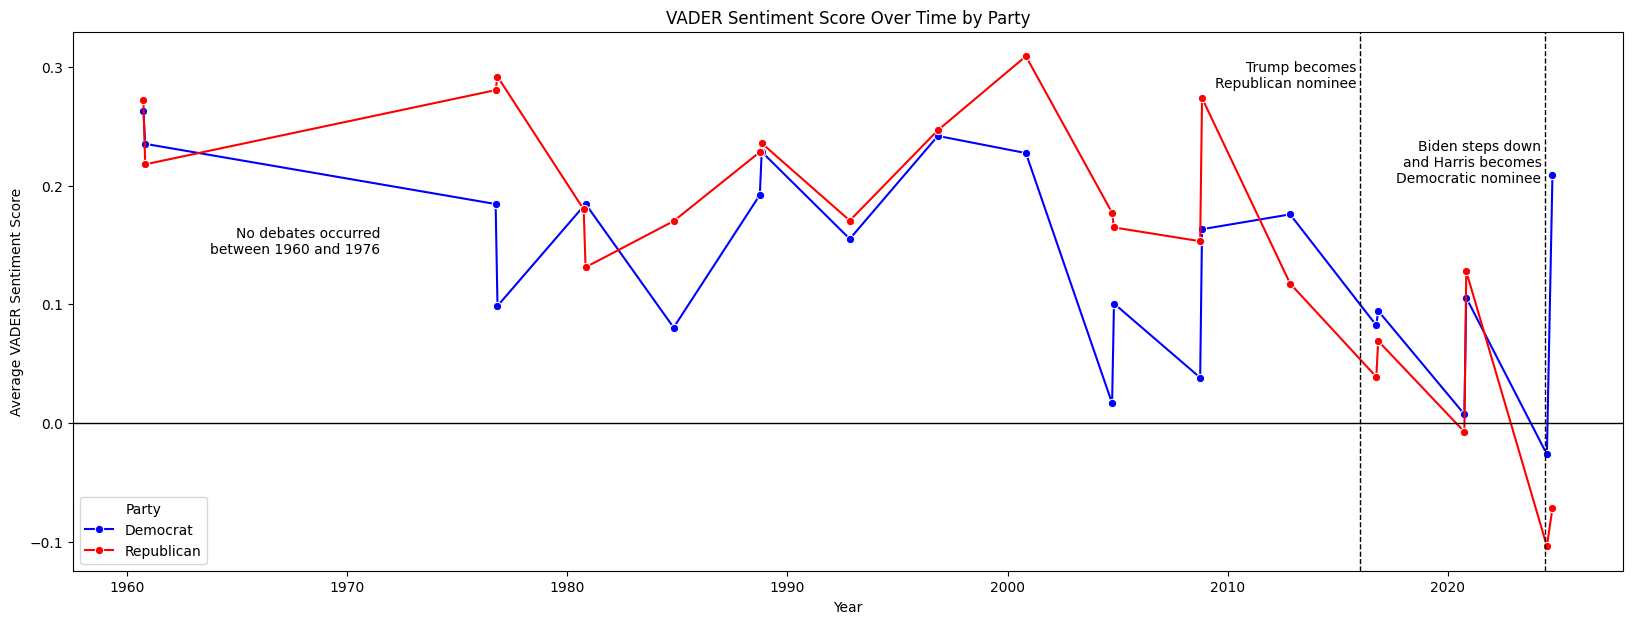

In [ ]:
df_time = df_split.set_index('date').groupby('Party').resample('ME')['compound'].mean().reset_index()

plt.figure(figsize=(20, 7))
sns.lineplot(data=df_time, x='date', y='compound', hue='Party', marker="o", palette=party_colors, errorbar=('ci', False))

# Add a horizontal line at y=0 to separate positive and negative
plt.axhline(0, color='black', linestyle='-', linewidth=1)

plt.grid(False)
plt.title("VADER Sentiment Score Over Time by Party")
plt.xlabel("Year")
plt.ylabel("Average VADER Sentiment Score")
plt.legend(title="Party")


# Lines for different events
plt.text(pd.to_datetime('1971-07-01'), 0.14, "No debates occurred\nbetween 1960 and 1976",
         rotation=0, verticalalignment='bottom', horizontalalignment='right', color='black')

plt.axvline(pd.to_datetime('2016-01-01'), color='black', linestyle='--', linewidth=1)
plt.text(pd.to_datetime('2015-11-01'), 0.28, "Trump becomes\nRepublican nominee",
         rotation=0, verticalalignment='bottom', horizontalalignment='right', color='black')

plt.axvline(pd.to_datetime('2024-06-01'), color='black', linestyle='--', linewidth=1)
plt.text(pd.to_datetime('2024-04-01'), 0.2, "Biden steps down\nand Harris becomes\nDemocratic nominee",
         rotation=0, verticalalignment='bottom', horizontalalignment='right', color='black')

plt.show();

In [ ]:
df_split

,actor,dialogue,date,Party,vader_scores,compound
0,Mr. Kennedy,"Good evening, Mr. Shadel.",1960-10-13,Democrat,"{'neg': 0.0, 'neu': 0.508, 'pos': 0.492, 'comp...",0.4404
1,Mr. Nixon,"Good evening, Mr. Shadel.",1960-10-13,Republican,"{'neg': 0.0, 'neu': 0.508, 'pos': 0.492, 'comp...",0.4404
2,Mr. Kennedy,"Mr. McGee, we have a contractual right to be i...",1960-10-13,Democrat,"{'neg': 0.08, 'neu': 0.804, 'pos': 0.115, 'com...",-0.0772
3,Mr. Kennedy,nations under NATO. Ive stated on many occasio...,1960-10-13,Democrat,"{'neg': 0.0, 'neu': 0.745, 'pos': 0.255, 'comp...",0.9001
4,Mr. Kennedy,that there is any doubt in the mind of any Ame...,1960-10-13,Democrat,"{'neg': 0.131, 'neu': 0.752, 'pos': 0.117, 'co...",-0.2023
...,...,...,...,...,...,...
16560,TRUMP,"All of the things that we've done, nobody's ev...",2024-06-27,Republican,"{'neg': 0.105, 'neu': 0.895, 'pos': 0.0, 'comp...",-0.6007
16561,TRUMP,"Now, you can go and you can get something. You...",2024-06-27,Republican,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
16562,TRUMP,But you know what we did for the military was ...,2024-06-27,Republican,"{'neg': 0.0, 'neu': 0.911, 'pos': 0.089, 'comp...",0.6486
16563,TRUMP,living. And that's why I had the highest appro...,2024-06-27,Republican,"{'neg': 0.0, 'neu': 0.819, 'pos': 0.181, 'comp...",0.4767


# ROBERTA Sentiment Analysis on Presidential & Vice-Presidential Debates

In [ ]:
# Perform sentiment analysis using ROBERTA model from Hugging Face
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name).to("cuda")

# Polarity score = sentiment score
def get_polarity_score(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to("cuda")
    outputs = model(**inputs)
    # Scores are probabilities for each class (positive, negative)
    scores = outputs.logits[0].softmax(dim=0).tolist()
    polarity_score = scores[2] - scores[0]
    return polarity_score

# Apply polarity score calculation to each dialogue
df_split['ROBERTA_score'] = df_split['dialogue'].apply(get_polarity_score)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

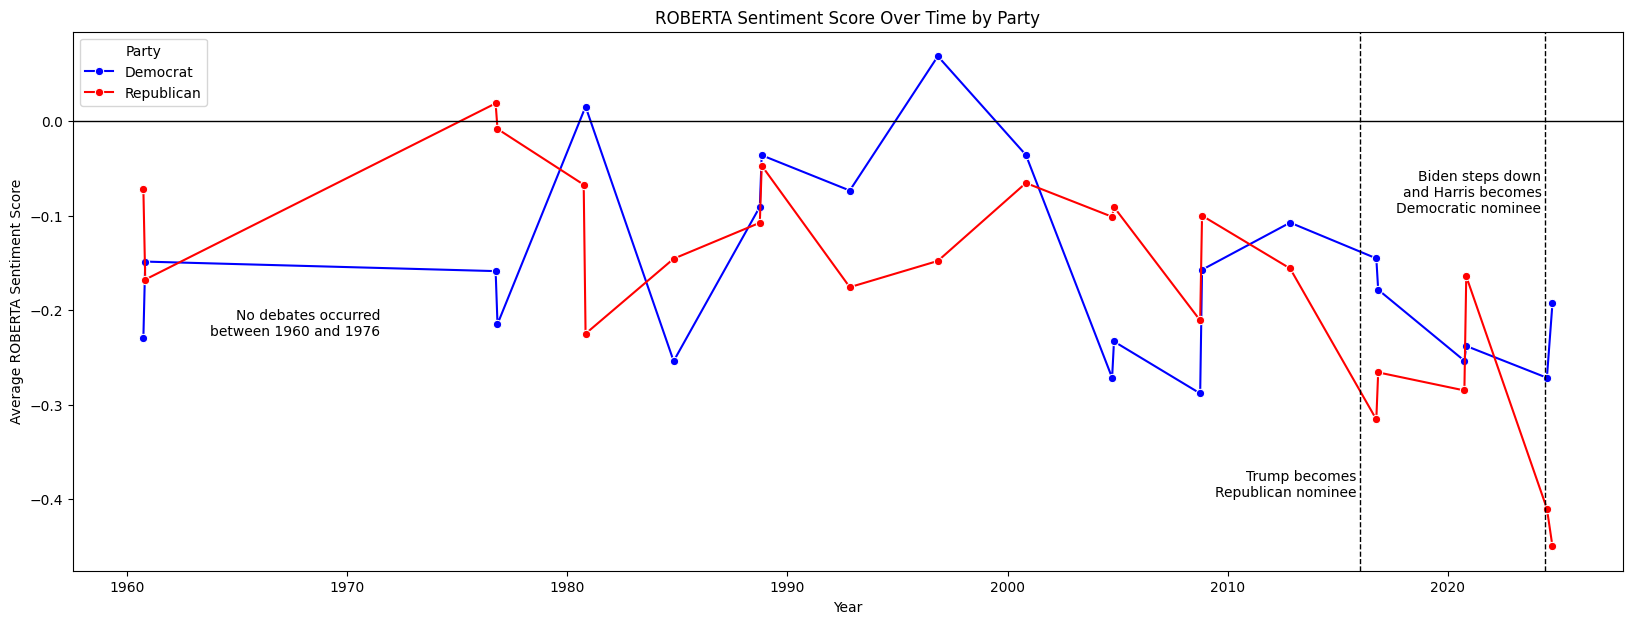

In [ ]:
df_time = df_split.set_index('date').groupby('Party').resample('ME')['ROBERTA_score'].mean().reset_index()

plt.figure(figsize=(20, 7))
sns.lineplot(data=df_time, x='date', y='ROBERTA_score', hue='Party', marker="o", palette = party_colors, errorbar=('ci', False))

# Add a horizontal line at y=0 to separate positive and negative
plt.axhline(0, color='black', linestyle='-', linewidth=1)

plt.grid(False)
plt.title("ROBERTA Sentiment Score Over Time by Party")
plt.xlabel("Year")
plt.ylabel("Average ROBERTA Sentiment Score")
plt.legend(title="Party")

# Lines for different events
plt.text(pd.to_datetime('1971-07-01'), -0.23, "No debates occurred\nbetween 1960 and 1976",
         rotation=0, verticalalignment='bottom', horizontalalignment='right', color='black')

plt.axvline(pd.to_datetime('2016-01-01'), color='black', linestyle='--', linewidth=1)
plt.text(pd.to_datetime('2015-11-01'), -.4, "Trump becomes\nRepublican nominee",
         rotation=0, verticalalignment='bottom', horizontalalignment='right', color='black')

plt.axvline(pd.to_datetime('2024-06-01'), color='black', linestyle='--', linewidth=1)
plt.text(pd.to_datetime('2024-04-01'), -0.1, "Biden steps down\nand Harris becomes\nDemocratic nominee",
         rotation=0, verticalalignment='bottom', horizontalalignment='right', color='black')

plt.show();

In [ ]:
df_split

,actor,dialogue,date,Party,vader_scores,compound,ROBERTA_score
0,Mr. Kennedy,"Good evening, Mr. Shadel.",1960-10-13,Democrat,"{'neg': 0.0, 'neu': 0.508, 'pos': 0.492, 'comp...",0.4404,0.684832
1,Mr. Nixon,"Good evening, Mr. Shadel.",1960-10-13,Republican,"{'neg': 0.0, 'neu': 0.508, 'pos': 0.492, 'comp...",0.4404,0.684832
2,Mr. Kennedy,"Mr. McGee, we have a contractual right to be i...",1960-10-13,Democrat,"{'neg': 0.08, 'neu': 0.804, 'pos': 0.115, 'com...",-0.0772,0.169045
3,Mr. Kennedy,nations under NATO. Ive stated on many occasio...,1960-10-13,Democrat,"{'neg': 0.0, 'neu': 0.745, 'pos': 0.255, 'comp...",0.9001,-0.153999
4,Mr. Kennedy,that there is any doubt in the mind of any Ame...,1960-10-13,Democrat,"{'neg': 0.131, 'neu': 0.752, 'pos': 0.117, 'co...",-0.2023,0.252811
...,...,...,...,...,...,...,...
16560,TRUMP,"All of the things that we've done, nobody's ev...",2024-06-27,Republican,"{'neg': 0.105, 'neu': 0.895, 'pos': 0.0, 'comp...",-0.6007,-0.446701
16561,TRUMP,"Now, you can go and you can get something. You...",2024-06-27,Republican,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,-0.162159
16562,TRUMP,But you know what we did for the military was ...,2024-06-27,Republican,"{'neg': 0.0, 'neu': 0.911, 'pos': 0.089, 'comp...",0.6486,0.592397
16563,TRUMP,living. And that's why I had the highest appro...,2024-06-27,Republican,"{'neg': 0.0, 'neu': 0.819, 'pos': 0.181, 'comp...",0.4767,0.888905


# GPT4-o mini Sentiment Analysis on Presidential & Vice-Presidential Debates

In [ ]:
# michelle's API key
api_key_me = userdata.get('NLP_OPENAI')
client = OpenAI(api_key=api_key_me)

def chatWithGPT(prompt):
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ]
    )

    return response.choices[0].message.content

# Define a function to categorize each response using GPT-4o-mini
def categorize_response(text):
    prompt = (f"Please analyze the sentiment of the following text. Provide a score between -1 and 1, where -1 represents very negative sentiment, 0 represents neutral sentiment, and 1 represents very positive sentiment. Only give the score, no explanation. Here is the text: {text}")
    # Call the GPT-4 o mini API
    return chatWithGPT(prompt)


In [ ]:
# Set up a counter to track progress throughout the run
processed_count = 0

# Saving every 100 rows
for i in range(len(last_remaining_df)):
    last_remaining_df.at[i, 'gpt_4_mini_score'] = categorize_response(last_remaining_df.at[i, 'dialogue'])

    # Increment the counter
    processed_count += 1

    # Print progress update every 10 rows
    if processed_count % 100 == 0:
        print(f"Processed {processed_count}/{len(last_remaining_df)} rows")

    # Save progress every 100 rows
    if processed_count % 100 == 0:
        last_remaining_df.to_csv('last_remaining_split_gpt.csv', index=False)
        print(f"Checkpoint: Saved progress at {processed_count} rows")

# Save final result after all rows are processed
last_remaining_df.to_csv('last_remaining_split_gpt.csv', index=False)
print("Processing complete. Final CSV saved.")

result = last_remaining_df

In [ ]:
result['test_score'] = result['gpt_4_mini_score'].str.extract(r'(-?\d+\.\d+|-?\d+)')[0].astype(float)

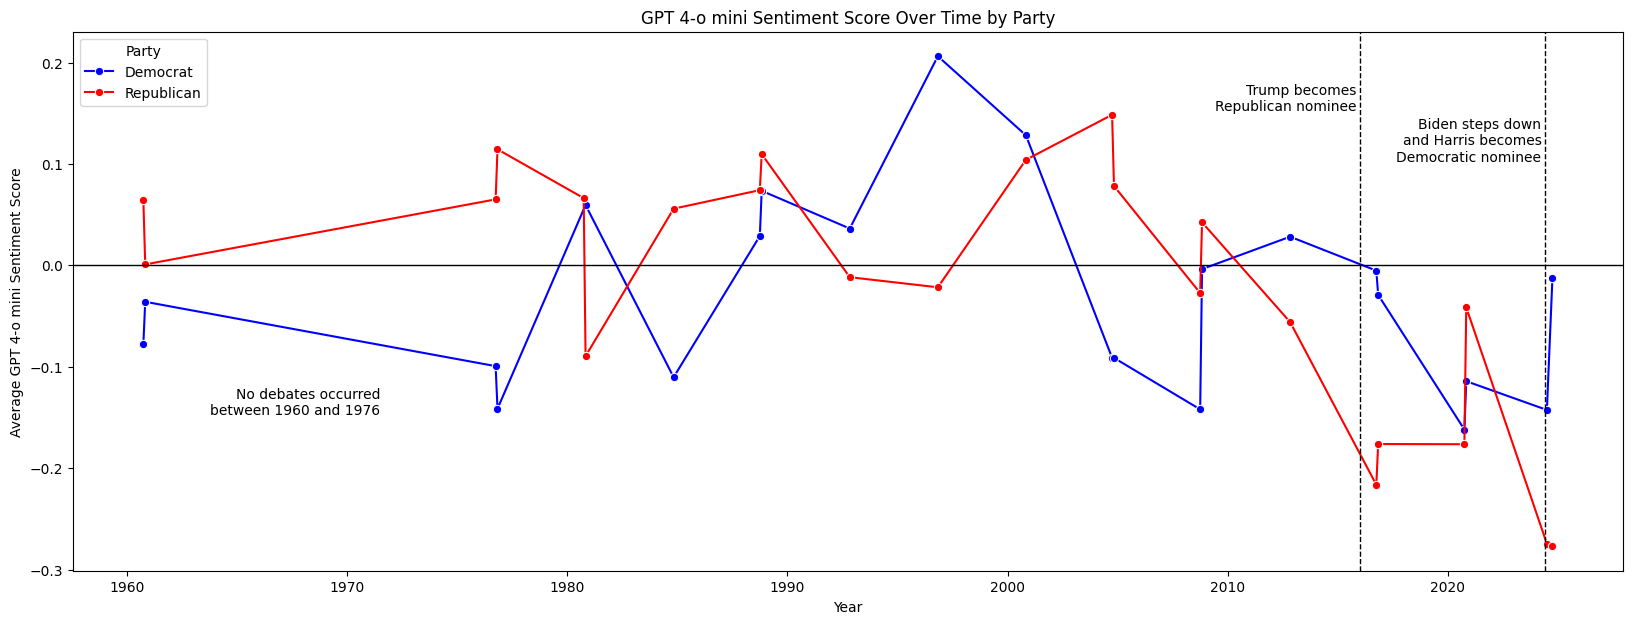

In [ ]:
result['date'] = pd.to_datetime(result['date'])
df_time = result.set_index('date').groupby('Party').resample('ME')['test_score'].mean().reset_index()


plt.figure(figsize=(20, 7))
sns.lineplot(data=df_time, x='date', y='test_score', hue='Party', marker="o", palette = party_colors, errorbar=('ci', False))

# Add a horizontal line at y=0 to separate positive and negative
plt.axhline(0, color='black', linestyle='-', linewidth=1)

plt.grid(False)
plt.title("GPT 4-o mini Sentiment Score Over Time by Party")
plt.xlabel("Year")
plt.ylabel("Average GPT 4-o mini Sentiment Score")
plt.legend(title="Party")

# Lines for different events
plt.text(pd.to_datetime('1971-07-01'), -0.15, "No debates occurred\nbetween 1960 and 1976",
         rotation=0, verticalalignment='bottom', horizontalalignment='right', color='black')

plt.axvline(pd.to_datetime('2016-01-01'), color='black', linestyle='--', linewidth=1)
plt.text(pd.to_datetime('2015-11-01'), 0.15, "Trump becomes\nRepublican nominee",
         rotation=0, verticalalignment='bottom', horizontalalignment='right', color='black')

plt.axvline(pd.to_datetime('2024-06-01'), color='black', linestyle='--', linewidth=1)
plt.text(pd.to_datetime('2024-04-01'), 0.1, "Biden steps down\nand Harris becomes\nDemocratic nominee",
         rotation=0, verticalalignment='bottom', horizontalalignment='right', color='black')

plt.show();